# Subiectul 1

### punctul a

In [6]:
import pymc as pm
import numpy as np
import pandas as pd

data = pd.read_csv('date_regresie.csv')

with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)
    beta3 = pm.Normal('beta3', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)

    mu = alpha + beta1 * data['Salariu'] + beta2 * data['Ore_lucrate'] + beta3 * data['Salariu'] * data['Ore_lucrate']

    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=data['Satisfactie'])

    trace = pm.sample(2000, tune=1000)

Output()

### punctul b

In [7]:
import arviz as az

hdi = az.hdi(trace, hdi_prob=0.94)
print(hdi)

<xarray.Dataset> Size: 128B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    alpha    (hdi) float64 16B -7.117 2.318
    beta1    (hdi) float64 16B 0.45 1.887
    beta2    (hdi) float64 16B -0.002123 0.2042
    beta3    (hdi) float64 16B -0.02306 0.008748
    sigma    (hdi) float64 16B 1.318 1.733


### punctul c
Analiza intervalelor de credibilitate ne permite sa tragem concluzii despre impactul salariului si orelor lucrate asupra satisfactiei angajatilor. Daca intervalul de credibilitate pentru un coeficient nu include zero, acel factor are un impact semnificativ asupra satisfactiei.

# Subiectul 2

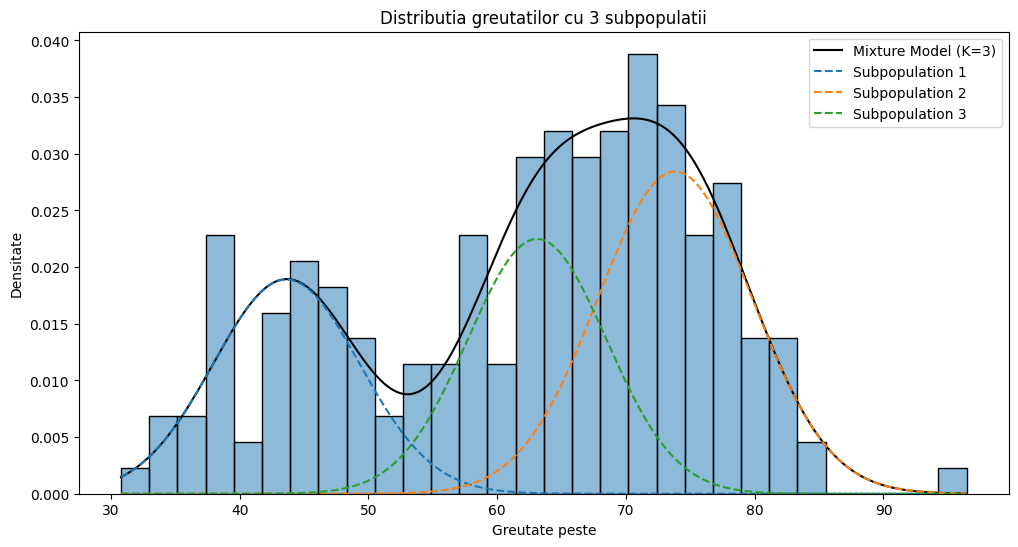


Rezultate pentru K=3 subpopulatii:

a) Probabilitatile de apartenenta:
Subpopulatia 1: 0.269
Subpopulatia 2: 0.428
Subpopulatia 3: 0.303

b) Criterii pentru selectia modelului:
K=3: BIC=1607.69, AIC=1581.31
K=4: BIC=1624.57, AIC=1588.29
K=5: BIC=1637.49, AIC=1591.31

c) Greutatile medii pentru fiecare subpopulatie:
Subpopulatia 1: 43.62
Subpopulatia 2: 63.09
Subpopulatia 3: 73.81


In [32]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import seaborn as sns

weights = pd.read_csv('greutati.csv')
data = weights['Greutate_pește'].values.reshape(-1, 1)

def calculate_criteria(data, k_range):
    results = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(data)
        results.append({
            'K': k,
            'BIC': gmm.bic(data),
            'AIC': gmm.aic(data),
            'GMM': gmm
        })
    return results

k_range = [3, 4, 5]
results = calculate_criteria(data, k_range)

best_model_idx = np.argmin([r['BIC'] for r in results])
best_k = k_range[best_model_idx]
best_model = results[best_model_idx]['GMM']

probs = best_model.predict_proba(data)
means = best_model.means_.flatten()
weights_sorted = np.sort(means)

plt.figure(figsize=(12, 6))
sns.histplot(data=weights, x='Greutate_pește', bins=30, stat='density', alpha=0.5)

x = np.linspace(data.min(), data.max(), 200).reshape(-1, 1)
logprob = best_model.score_samples(x)
responsibilities = best_model.predict_proba(x)
pdf = np.exp(logprob)
plt.plot(x, pdf, 'k-', label=f'Mixture Model (K={best_k})')

for i in range(best_k):
    pdf_individual = responsibilities[:, i] * pdf
    plt.plot(x, pdf_individual, '--', label=f'Subpopulation {i+1}')

plt.xlabel('Greutate peste')
plt.ylabel('Densitate')
plt.title(f'Distributia greutatilor cu {best_k} subpopulatii')
plt.legend()
plt.show()

print(f"\nRezultate pentru K={best_k} subpopulatii:")
print("\na) Probabilitatile de apartenenta:")
for i in range(best_k):
    print(f"Subpopulatia {i+1}: {best_model.weights_[i]:.3f}")

print("\nb) Criterii pentru selectia modelului:")
for r in results:
    print(f"K={r['K']}: BIC={r['BIC']:.2f}, AIC={r['AIC']:.2f}")

print("\nc) Greutatile medii pentru fiecare subpopulatie:")
for i, mean in enumerate(weights_sorted):
    print(f"Subpopulatia {i+1}: {mean:.2f}")

###aici folosim loo si waic

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

weights = pd.read_csv('greutati.csv')
data = weights['Greutate_pește'].values

k_range = [3, 4, 5]
waic_results = []
loo_results = []
best_model = None
best_k = None
best_waic = np.inf

for k in k_range:
    with pm.Model() as model:
        weights = pm.Dirichlet('weights', a=np.ones(k))
        means = pm.Normal('means', mu=np.mean(data), sigma=np.std(data), shape=k)
        sigmas = pm.HalfNormal('sigmas', sigma=np.std(data), shape=k)
        category = pm.Categorical('category', p=weights, shape=len(data))
        likelihood = pm.Normal('likelihood', mu=means[category], sigma=sigmas[category], observed=data)
        trace = pm.sample(1000, tune=1000, return_inferencedata=True, target_accept=0.9)
        waic = az.waic(trace)
        loo = az.loo(trace)
        waic_results.append(waic.waic)
        loo_results.append(loo.loo)
        if waic.waic < best_waic:
            best_waic = waic.waic
            best_k = k
            best_model = trace

print(f"Cel mai bun model este pentru K={best_k} conform WAIC.")
print("\nRezultatele WAIC pentru fiecare K:")
for k, waic in zip(k_range, waic_results):
    print(f"K={k}: WAIC={waic:.2f}")

print("\nRezultatele LOO pentru fiecare K:")
for k, loo in zip(k_range, loo_results):
    print(f"K={k}: LOO={loo:.2f}")

az.plot_trace(best_model)
plt.show()
